In [ ]:
using FFTW
using LinearAlgebra
using Plots

In [ ]:
cmd = `jupyter-nbconvert presentation.ipynb --to slides --TagRemovePreprocessor.remove_input_tags=\{\"remove_input\"\} --post serve --ServePostProcessor.port=9997 --ServePostProcessor.ip=\"0.0.0.0\"`
run(cmd);

To render slides, interrupt the above cell (esc + I), then rerun it.

Slides are rendered to

http://72.179.3.141:9997/presentation.slides.html

For pdf version:

http://72.179.3.141:9997/presentation.slides.html?print-pdf

<center><h1>GPU Filter Banks for Audio</h1></center>

<center><h2>Dan Jacobellis<br>Utsha Khondkar</h2></center>

* Introduce team

Our project is on adapting filter banks which are used in audio applications to the GPU.

You might not be familiar with the terminology "filter bank". But, you've probably seen a filter bank before, it just might have been called something else.

For example, the fast fourier transform, the FFT, can be considered a a type of filter bank. In fact this picture right here is actually showing the filter coefficients that you could use to perform a discrete fourier transform. 

So why do we care about filter banks?

![](img/fft_matrix.svg)

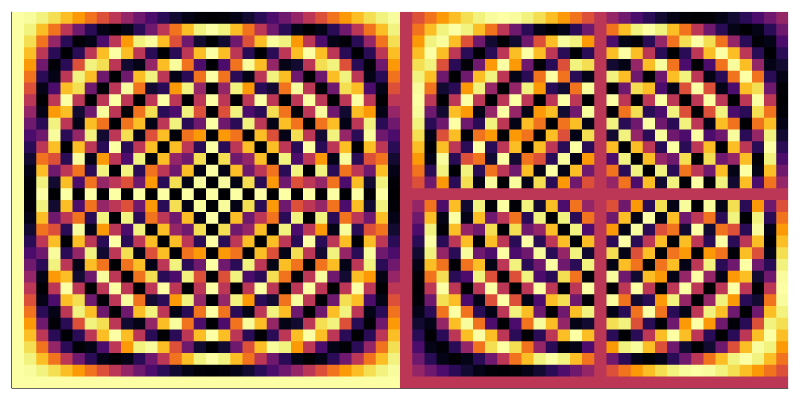

In [ ]:
X = fft(Matrix(1.0I,32,32), 1);
heatmap([real(X) imag(X)], axis=nothing, colorbar=nothing,size=(800,400))

<center><h1>Time-Frequency Analysis</h1></center>

Filter banks are the primary tool of time-frequency analysis, and time-frequency analysis is the primary tool of audio signal processing.

In practice, most audio signals are difficult to deal with in the time domain.

Sometimes, we can get away with just taking a Fourier transform to put it into the frequency domain.

Usually, the most useful representation is somewhere in between.

As an example, let's listen to this bird chirp

<video width="800" height="400" controls src="img/chirp.mp4" />

Now, let's look at it in the time domain, the frequency domain, and as a joint time-frequency representation.

<center><h1>Time-Frequency Analysis</h1></center>

![](img/chirp.svg)

If we were to just look at it in the time domain, we might have some idea about when these chirps occur or how loud they are.

If we were were to just look at it in the frequency domain, we would have some idea of what frequencies are present, but not necessarily when they occur or how they change.

The joint representation is where most of the interesting problems are solved.

For example, it's easy to see, for the chirp, where the signal is and where the noise is.

In the time or frequency domains, the signal is everywhere. In the time-frequency domain, the signal occupies a relatively small area.

Our auditory systems exploit this. The anatomy of our inner ears are actually performing a type of time-frequency analysis.

The current approaches to machine learning for audio start by constructing some sort of time-frequency representation like this.

The question is: what is the best way to construct these things, and how do we do it efficiently in parallel?

<center><h1>Filter Banks</h1></center>

![](img/helmholtz.png)

The basic tool to construct a time-frequency distribution is the filter bank.

We just take a bunch of filters which each respond to a narrow range of frequencies, and run the signal through each of the filters in parallel.

This idea has been around for a long time.

This is one of the first analog filter banks which used these things called helmholtz resonators which behave as a bandpass filter. This was created by Hemlholtz who was one of the pioneers in audio signal processing, even if we didn't call it 'signal processing' back then.

Now, we use digital filters, which are applied using discrete convolution.

As you probably know, GPUs are really good at doing convolution.

But for whatever reason, most people only ever use one type of filterbank because it's easy and there's lots of accessible software to do it. That's the FFT.

<center><h1>FFT as a filter bank</h1></center>

The image I showed earlier was made using an FFT. Even though the FFT takes a signal from the time domain and puts it into the frequency domain, we can use it to make a joint representation.

All we have to do is take short windows of the signal and apply the FFT to each window. When you do that, you're basically tiling the time-frequency plane like this

The problem with this representation is that the frequency bands are uniformly spaced. For a lot of tasks, we really want a constant-Q spacing

<img width="500" src="img/uniform_tile.png" />

<center><h1>Constant-Q</h1></center>

$$ Q = \frac{\text{center frequency}}{\text{bandwidth}} $$

<img width="500" src="img/cq_tiling.png"/> 

A Constant Q representation divides the frequency axis so that each frequency band has the same Q factor.

The Q factor is just the ratio of the center frequency to bandwidth.

In this example, The Q factor is chosen so that each of these frequency bands is an octave.

For signals like speech or music which are for human consumption, this type of representation is preferred because it matches our perception. We have better ability to discriminate small differences of frequency when the frequencies are low. But at the same time, we have a better ability to track changes over time when the frequencies are high.

<center><h1>Wavelets</h1></center>

<img width="800" src="img/trends1.svg"/> 

These types of transforms can be achieved using something called a discrete wavelet transform, which is really just a type of filterbank.

However, deep learning has displaced most of the study of wavelets, and people stopped writing software and algorithms for them.

Even though they've been around for a long time, doing discrete wavelet transforms on the GPU is a pretty arcane task. 

<center><h1>Mel Filter Banks</h1></center>

<img width="800" src="img/trends2.svg"/> 

Since audio signal processing is a very interdisciplinary field, and people don't have time to become an expert on discrete wavelet transforms and filter banks, most people end up using something called a mel filterbank to do these constant q transforms.

<center><h1>What's wrong with FFTs and Mel Filters?</h1></center>

For audio signal processing problems such as compression, denoising, and various types of pattern recognition, deep learning has taken over. For example, the search interest for "wavelet" has followed the opposite trajectory as "convolutional neural network"

A current trend of audio signal processing research is to apply 2D convolutional neural networks to time-frequency representations of audio. Although great progress was made in the pre-deep learning era on perfect reconstruction filterbanks and wavelet transforms, most of the algorithms and techniques have been abandoned by practitioners of deep learning because no standardized and free implementations were ever widely disseminated. As a result, the standarized set of triangular "Mel" filterbanks dating back nearly 50 years appears to have remained the dominant tool, and have even seen a resurgance despite their [impending obsolescence.][1]

![](img/trends2.png)

The use of these methods is accumulating a considerable debt. Compared to the most recent iterations of constant-Q filterbanks, these methods for time-frequency analysis lack several desirable properties

* Parameterization/tunability
* Perfect reconstruction
* Meaningful/interpretable phase representation
* Generalization to multiple channels/phased arrays
* Efficient implementation for oversampled representations.

[1]:https://asmp-eurasipjournals.springeropen.com/articles/10.1186/s13636-021-00217-4

# Filter Banks and Wavelet Transforms

Filter banks are the oldest method of time-frequency analysis, dating back to the first analog spectrum analyzer built by Hermann von Helmholtz in the 19th century.



In 1909, mathematician Alfréd Haar discovered that a list of $2^n$ numbers can be represented by recursively taking the sum and difference of adjacent pairs. This property is now commonly referred to 'alias cancellation'

In the 1970s, engineers created the first discrete, invertible filterbanks by expoiting this property. Using what are known as 'conjugate mirror filters'. In the following decade, a massive research effort took place, resulting in a rigorous mathematical understanding of these processes and the development of various "wavelet transforms."

Unfortunately, deep learning has begun to displace these techniques in education, leading to considerable confusion and technical debt.

# Haar Decomposition
(Draft) Haar decomposition is one of the simplest wavelet transform that has perfect reconstruction property, thus is a good introduction example. First of all, note that the input is a sequence of integers, because we are dealing digital data after sampling from raw data, such as audio. By performing two convolutions with the input, we get a low-frequency component and a high-frequency component.
As we can see, the sum and difference of the high and low frequency components forms a splitted signal of the original signal, which we can merge to retain the original one. This is an example of “critically sampled” dyadic filterbank, which means that the size of data after applying the filter is exactly same as original data. Note that, “dyadic filters” refers “dynamic analysis filters”, the type of filtering that consists of a filtering followed by downsampling. There is an inverse operation, which is synthetic filters. (Which we are dealing by convolution. We will get to this detail later)

In [ ]:
x = round.(Int,10*randn(8));

In [ ]:
print(x)

[7, 1, -13, 20, 4, 7, -18, 5]

In [ ]:
s = conv(x,[1, 1])[2:2:end];
d = conv(x,[1,-1])[2:2:end];

In [ ]:
println("s = ",s); print("d = ",d)

s = [8, 7, 11, -13]
d = [-6, 33, 3, 23]

In [ ]:
y1 = (s-d)/2;
y2 = (s+d)/2;

In [ ]:
println(Int.(y1)); print(Int.(y2))

[7, -13, 4, -18]
[1, 20, 7, 5]

This is an example of a **critically sampled** dyadic filterbank

# Time-frequency tiling



Decomposing the lower branch produces octave filters

img/dyadic_analysis_filterbank.svg

![](img/octave_tiling.png)


Decomposing both branches (balanced tree)

(uniform grid of rectangles) 

you can have anything in the middle

(Draft)
In the Haar decomposition, we received two signals with half time resolution but twice the frequency resolution signals, by applying the filters. Next, we introduce a more fine-grained time-frequency tiling pattern, as shown in the image.

This structure has the benefit of a simple data structure, since each tile is a vector, while providing the exact trade-off between the frequency resolution and the time resolution as we want.

# Decimation filterbank

filter then downsample

!= dilation + stride (but close)

show toeplitz matrix multiplication with upsampling/downsampling

# Polyphase filterbank

upsample then filter
 
?= transposed convolution with dilation and stride

Another oppurtunity to add CPU parallelism

show mathematically that it's equivalent to splitting filter into L pieces where L is the upsampling factor, and applying filters in parallel



# Oversampled filterbanks

(Draft) Oversampled filterbanks refers to the type of filterbank that results in larger sized output data compared to the input. For example, Fourier Transform is an oversampled filtering with factor 2, as it yields a signal in frequency domain and the phase domain. 

Because of this nature, oversampled filterbank can get better CPU parallelism by having multiple data pipeline.

# Undersampled filterbanks

(Draft) In contrast to oversampled filterbanks, undersampled filterbank results in smaller sized output data compared to the input data. An example is convolving input signal with a small kernal without paddings.

# Analysis filterbank

# Synthesis filterbank

# Processing

* denoising
* compression
* source separation

# Octave Filters + Balanced Filters

In our filter, we repeatedly apply analysis filters to break down the input signal and synthesis filters to reconstruct from broken down (and possibly processed) pieces. As shown in the earlier image, this has an unbalanced tree structure where we apply analysis filters to the higher frequency-band output at each level, but leave the lower frequency-band output. This is a natural structure, as human ear processes sound signals in a similar way. 

In our algorithm, we break down the signal into 11 octaves, as 11 is mostly sufficient to cover human’s hearing capability. As a result, we get 11 vectors, where higher frequency blocks have better resolution.  Note that, we can apply any operation on these vectors and still retain the reconstruction property, as long as the operation has the mirror-conjugate property.

Following the octave-spaced analysis filter, we apply dyadic filters in a balanced-tree fashion (i.e. apply filters to both high and low frequency outputs), to obtain some fixed frequency-resolution blocks out of the imbalanced length blocks from the previous step. 

Now, we have obtained 11 blocks of signals, decomposed from the orignal signal, where each block has the exact same frequency resolutions. We can see this as a feature representatino of the original data, where the features size is exactly same as original (i.e. critially sampled). 

Later, we will demonstrate the ease of use with this decomposition. We can perform various useful operations such as denoising and comporession with very simple code, and it is highly efficient due to massive parallelism.

# Demo our program